# Calculating mRNA level following CRISPRi using qPCR - Fig S1

This code takes raw qPCR data and converts it to relative mRNA expression level for any gene of interest. This data was gathered by growing cells expressing a single sgRNA in M9 + ATc for 5.5 hours and then isolating cellular mRNA. Also, when growth rate data is provided, can correlate mRNA concentration to growth rate. Imperfect correlations could illuminate the expression-to-growth rate transformation that takes place for each of these genes, which is a major benefit of using titrated CRISPRi.

Written by Ryan Otto 

Last edited 8 July 2020

## Import useful libraries

In [1]:
import pickle # Moving data
import numpy as np # Data organization
import pandas as pd # Data organization
import math # Calculating square roots and powers
from scipy import stats # Calculating linear regression and sem
import matplotlib.pyplot as plt # Plotting function
# Renders figures in notebook
%matplotlib inline

## Establish paths and variables unique to this analysis

In [2]:
input_path = 'inputs/' # General path for input files
figure_path = 'Figures/' # General path for saving figures
df_path = 'outputs/' # General path for data frames
growth_path = 'inputs/20200509_turb_pilot.csv' # Path for growth rate data frame

# List of all input files containing qPCR data
file_list = ['20190808_luna_rtqpcr_quant.csv', '20200212_luna_rtqpcr_quant.csv', '20200221_luna_rtqpcr_quant.csv']
# List of all genes to be analyzed
gene_list = ['dapA', 'dapB', 'serC', 'purC']
# Ordered list of mismatches, ending with the negative control (no knockdown)
guide_MM = ['0', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'negC']

date = '20200923' # Date for output files

## Import data

In [3]:
cq_dict = {}
for gene in gene_list:
    cq_dict[gene] = {}
cq_dict['hcaT'] = {}
for gene in gene_list:
    for num in guide_MM:
        cq_dict[gene][gene + '_' + num] = []
        cq_dict['hcaT'][gene + '_' + num] = []
for file_name in file_list:
    with open(input_path + file_name, 'r') as f:
        first_line = f.readline()
        for line in f:
            sp = line.split(',')
            if sp[2] != '' and sp[5] != '':
                cq_dict[sp[2]][sp[4]].append(float(sp[5]))

# Import and format growth rate data
df_turb_growth = pd.read_csv(growth_path, index_col=0, parse_dates=True)
df_turb_growth.drop('std', axis=1)
df_turb_growth['sem'] = df_turb_growth.sem(axis=1)

# Isolate growth rate data for each gene
turb_dict = {}
turb_dict['purC'] = df_turb_growth[36:48]
turb_dict['dapA'] = df_turb_growth[:12]
turb_dict['dapB'] = df_turb_growth[12:23]
turb_dict['serC'] = df_turb_growth[72:]

## qPCR Data Analysis

Takes triplicate measurements of sgRNA abundance and normalizes by a reference gene (hcaT). Uses a non-targeting negC sgRNA to calculate relative expression level following knockdown.

In [4]:
# Isolate raw Cq values
cq_raw_dict = {}
for gene in gene_list:
    cq_raw_dict[gene] = [0] * len(guide_MM)
    cq_raw_dict['hcaT_' + gene] = [0] * len(guide_MM)

    for i, num in enumerate(guide_MM):
        cq_raw_dict[gene][i] = cq_dict[gene][gene + '_' + num]
        cq_raw_dict['hcaT_' + gene][i] = cq_dict['hcaT'][gene + '_' + num]

In [5]:
# Normalize Cq values to calculate linearized relative RNA abundances
cq_mean_dict = {}
cq_sem_dict = {}
d_cq_mean_dict = {}
d_cq_sem_dict = {}
dd_cq_mean_dict = {}
dd_cq_sem_dict = {}
dd_cq_mean_lin_dict = {}
dd_cq_sem_lin_dict = {}

for gene in gene_list:
    # Calculate means for gene of interest and corresponding hcaT abundance
    cq_mean_dict[gene] = [np.mean(x) for x in cq_raw_dict[gene]]
    cq_sem_dict[gene] = [stats.sem(x) for x in cq_raw_dict[gene]]
    cq_mean_dict['hcaT_' + gene] = [np.mean(x) for x in cq_raw_dict['hcaT_' + gene]]
    cq_sem_dict['hcaT_' + gene] = [stats.sem(x) for x in cq_raw_dict['hcaT_' + gene]]
    # Normalize by hcaT abundance
    d_cq_mean_dict[gene] = [x - y for x, y in zip(cq_mean_dict['hcaT_' + gene], cq_mean_dict[gene])]
    d_cq_sem_dict[gene] = [math.sqrt(x**2 + y**2) for x, y in zip(cq_sem_dict['hcaT_' + gene], cq_sem_dict[gene])]
    # Normalize by abundance in presence of negC sgRNA
    dd_cq_mean_dict[gene] = [x - d_cq_mean_dict[gene][-1] for x in d_cq_mean_dict[gene]]
    dd_cq_sem_dict[gene] = [math.sqrt(x**2 + d_cq_sem_dict[gene][-1]**2) for x in d_cq_sem_dict[gene]]
    # Take off of log2 scale
    dd_cq_mean_lin_dict[gene] = [math.pow(2, x) for x in dd_cq_mean_dict[gene]]
    dd_cq_sem_lin_dict[gene] = [x * y * np.log(2) for x, y in zip(dd_cq_sem_dict[gene], dd_cq_mean_lin_dict[gene])]

/Users/rotto/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/rotto/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/rotto/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/rotto/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/rotto/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## qPCR Data Visualization and Growth Rate Correlation

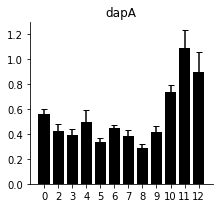

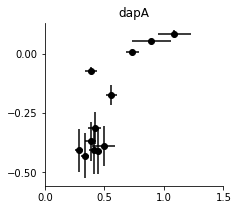

In [6]:
# Figures S1A and S1E
gene = 'dapA'
# Pull data only for guides with qPCR and growth rate data
data = dd_cq_mean_lin_dict[gene][:-1]
data_err = dd_cq_sem_lin_dict[gene][:-1]
tick_label = guide_MM[:-1]
index = np.arange(len(data))

plt.figure(figsize=(3.2, 3.0))
plt.bar(index, data, yerr=data_err, color='k', ecolor='k', capsize=3, lw= 0.5)
plt.xticks(index, tick_label)
plt.title(gene)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(figure_path + date + '_qPCR_bar_' + gene + '_FigS1A.pdf', transparent=True)
plt.show()


plt.figure(figsize=(3.2, 3.0))
for i, num in enumerate(guide_MM[:-1]):
    if num not in tick_label:
        continue
    elif len(num) == 1:
        turb_growth = turb_dict[gene]['mean'].filter(like='0' + num, axis=0)
        turb_sem = turb_dict[gene]['sem'].filter(like='0' + num, axis=0)
    else:
        turb_growth = turb_dict[gene]['mean'].filter(like=num, axis=0)
        turb_sem = turb_dict[gene]['sem'].filter(like=num, axis=0) 

    plt.errorbar(dd_cq_mean_lin_dict[gene][i], turb_growth, xerr=dd_cq_sem_lin_dict[gene][i], yerr=turb_sem, 
                 fmt='o', color='k')

plt.xlim([0, 1.5])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks([-0.5, -0.25, 0])
plt.title(gene)
plt.savefig(figure_path + date + '_qPCR_Corr_' + gene + '_FigS1E.pdf', transparent=True)
plt.show()

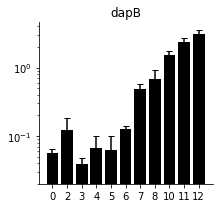

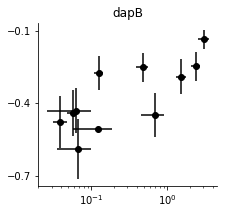

In [7]:
# Figures S1B and S1F
gene = 'dapB'
# Pull data only for guides with qPCR and growth rate data
data = np.concatenate((dd_cq_mean_lin_dict[gene][0:8], dd_cq_mean_lin_dict[gene][9:-1]))
data_err = np.concatenate((dd_cq_sem_lin_dict[gene][0:8], dd_cq_sem_lin_dict[gene][9:-1]))
tick_label = np.concatenate((guide_MM[0:8], guide_MM[9:-1]))
index = np.arange(len(data))

plt.figure(figsize=(3.2, 3.0))
plt.bar(index, data, yerr=data_err, color='k', ecolor='k', capsize=3, lw=0.5)
plt.xticks(index, tick_label)
plt.yscale('log')
plt.title(gene)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(figure_path + date + '_qPCR_bar_' + gene + '_FigS1B.pdf', transparent=True)
plt.show()

plt.figure(figsize=(3.2, 3.0))
for i, num in enumerate(guide_MM[:-1]):
    if num not in tick_label:
        continue
    elif len(num) == 1:
        turb_growth = turb_dict[gene]['mean'].filter(like='0' + num, axis=0)
        turb_sem = turb_dict[gene]['sem'].filter(like='0' + num, axis=0)
    else:
        turb_growth = turb_dict[gene]['mean'].filter(like=num, axis=0)
        turb_sem = turb_dict[gene]['sem'].filter(like=num, axis=0) 
    plt.errorbar(dd_cq_mean_lin_dict[gene][i], turb_growth, xerr=dd_cq_sem_lin_dict[gene][i], yerr=turb_sem, 
                     fmt='o', color='k')
plt.xscale('log')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks([-0.7, -0.4, -0.1])
plt.title(gene)
plt.savefig(figure_path + date + '_qPCR_Corr_' + gene + '_FigS1F.pdf', transparent=True)
plt.show()

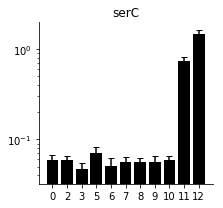

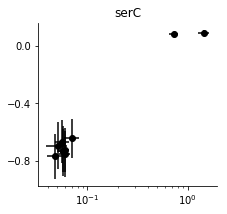

In [8]:
# Figures S1C and S1G
gene = 'serC'
# Pull data only for guides with qPCR and growth rate data
data = np.concatenate((dd_cq_mean_lin_dict[gene][0:3], dd_cq_mean_lin_dict[gene][4:-1]))
data_err = np.concatenate((dd_cq_sem_lin_dict[gene][0:3], dd_cq_sem_lin_dict[gene][4:-1]))
tick_label = np.concatenate((guide_MM[0:3], guide_MM[4:-1]))
index = np.arange(len(data))

plt.figure(figsize=(3.2, 3.0))
plt.bar(index, data, yerr=data_err, color='k', ecolor='k', capsize=3, lw=0.5)
plt.xticks(index, tick_label)
plt.yscale('log')
plt.title(gene)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(figure_path + date + '_qPCR_bar_' + gene + '_FigS1C.pdf', transparent=True)
plt.show()

plt.figure(figsize=(3.2, 3.0))
for i, num in enumerate(guide_MM[:-1]):
    if num not in tick_label:
        continue
    elif len(num) == 1:
        turb_growth = turb_dict[gene]['mean'].filter(like='0' + num, axis=0)
        turb_sem = turb_dict[gene]['sem'].filter(like='0' + num, axis=0)
    else:
        turb_growth = turb_dict[gene]['mean'].filter(like=num, axis=0)
        turb_sem = turb_dict[gene]['sem'].filter(like=num, axis=0) 

    plt.errorbar(dd_cq_mean_lin_dict[gene][i], turb_growth, xerr=dd_cq_sem_lin_dict[gene][i], yerr=turb_sem, 
                 fmt='o', color='k')

plt.xscale('log')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks([-0.8, -0.4, 0])
plt.title(gene)
plt.savefig(figure_path + date + '_qPCR_Corr_' + gene + '_FigS1G.pdf', transparent=True)
plt.show()

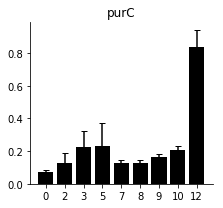

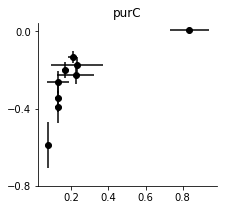

In [9]:
# Figures S1D and S1H
gene = 'purC'
# Pull data only for guides with qPCR and growth rate data
data = np.concatenate((dd_cq_mean_lin_dict[gene][0:3], dd_cq_mean_lin_dict[gene][4:5], 
                       dd_cq_mean_lin_dict[gene][6:10], dd_cq_mean_lin_dict[gene][11:-1]))
data_err = np.concatenate((dd_cq_sem_lin_dict[gene][0:3], dd_cq_sem_lin_dict[gene][4:5], 
                           dd_cq_sem_lin_dict[gene][6:10], dd_cq_sem_lin_dict[gene][11:-1]))
tick_label = np.concatenate((guide_MM[0:3], guide_MM[4:5], guide_MM[6:10], guide_MM[11:-1]))
index = np.arange(len(data))

plt.figure(figsize=(3.2, 3.0))
plt.bar(index, data, yerr=data_err, color='k', ecolor='k', capsize=3, lw=0.5)
plt.xticks(index, tick_label)
plt.title(gene)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(figure_path + date + '_qPCR_bar_' + gene + '_FigS1D.pdf', transparent=True)
plt.show()

plt.figure(figsize=(3.2, 3.0))
for i, num in enumerate(guide_MM[:-1]):
    if num not in tick_label:
        continue
    elif len(num) == 1:
        turb_growth = turb_dict[gene]['mean'].filter(like='0' + num, axis=0)
        turb_sem = turb_dict[gene]['sem'].filter(like='0' + num, axis=0)
    else:
        turb_growth = turb_dict[gene]['mean'].filter(like=num, axis=0)
        turb_sem = turb_dict[gene]['sem'].filter(like=num, axis=0) 

    plt.errorbar(dd_cq_mean_lin_dict[gene][i], turb_growth, xerr=dd_cq_sem_lin_dict[gene][i], yerr=turb_sem, 
                 fmt='o', color='k')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks([-0.8, -0.4, 0])
plt.title(gene)
plt.savefig(figure_path + date + '_qPCR_Corr_' + gene + '_FigS1H.pdf', transparent=True)
plt.show()